# DAE with absolute value function and sign function in constraint
# LCP implementation

In this simulation we consider the sytem

$$\left\{
        \begin{aligned}
            \dot{x}_1 =& 1 + \text{B}_1z \\
            \dot{x}_2 =& \text{B}_2z \\
            0 =& |x_1| + \texttt{sign}(x_1) - x_2 
            \end{aligned}\right.$$
    
Here multiple values of $B_0$ and $B_1$ are considered as they strongly affects the numerical results. 
In addition, in this particular Jupyter file we only consider the representation of the absolute value function and the sign function by some complementary constraints.

In particular, we can obtain two equivalent formulation of the first system:
The first one is:

$$            \left\{
                \begin{aligned}
                    \dot{x}_1 =& 1 + \text{B}_1z \\
                    \dot{x}_2 =& \text{B}_2z \\
                     0 =& x_1- x_2 -1  + \text{r}(\boldsymbol{\lambda})\\
                     \text{r}(\boldsymbol{\lambda}) =& \lambda_1 + \lambda_2 \\
                      0\leq 2x_1 + \lambda_1&\perp \lambda_1 \geq 0\\
                      0\leq \lambda_3-x_1 &\perp \lambda_2 \geq 0\\
                      0\leq 2-\lambda_2 &\perp \lambda_3 \geq 0
                \end{aligned}
            \right.$$

And the second one is:
$$            \left\{
                \begin{aligned}
                    \dot{x}_1 =& 1 + \text{B}_1z \\
                    \dot{x}_2 =& \text{B}_2z \\
                     0 =& x_1- x_2 + 1  + \text{r}(\boldsymbol{\lambda})\\
                     \text{r}(\boldsymbol{\lambda}) =& \lambda_1 - \lambda_2 \\
                      0\leq 2x_1 + \lambda_1&\perp \lambda_1 \geq 0\\
                      0\leq \lambda_3+x_1 &\perp \lambda_2 \geq 0\\
                      0\leq 2-\lambda_2 &\perp \lambda_3 \geq 0
                \end{aligned}
            \right.$$


In the code one of the two representation is commented, while the other is active. It is important to note that due to the non-uniqueness of the numerical solution the simulation may yield different results.


A = 
[[ 0.   0.   0.5]
 [ 0.   0.   1. ]
 [ 1.  -1.   0. ]]
b = 
[1, 0, 1]
E = 
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]
R = 
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 1. -1.  0.]]
C = 
[[ 2.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  0.]]
D = 
[[ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0. -1.  0.]]
10001


<IPython.core.display.Javascript object>


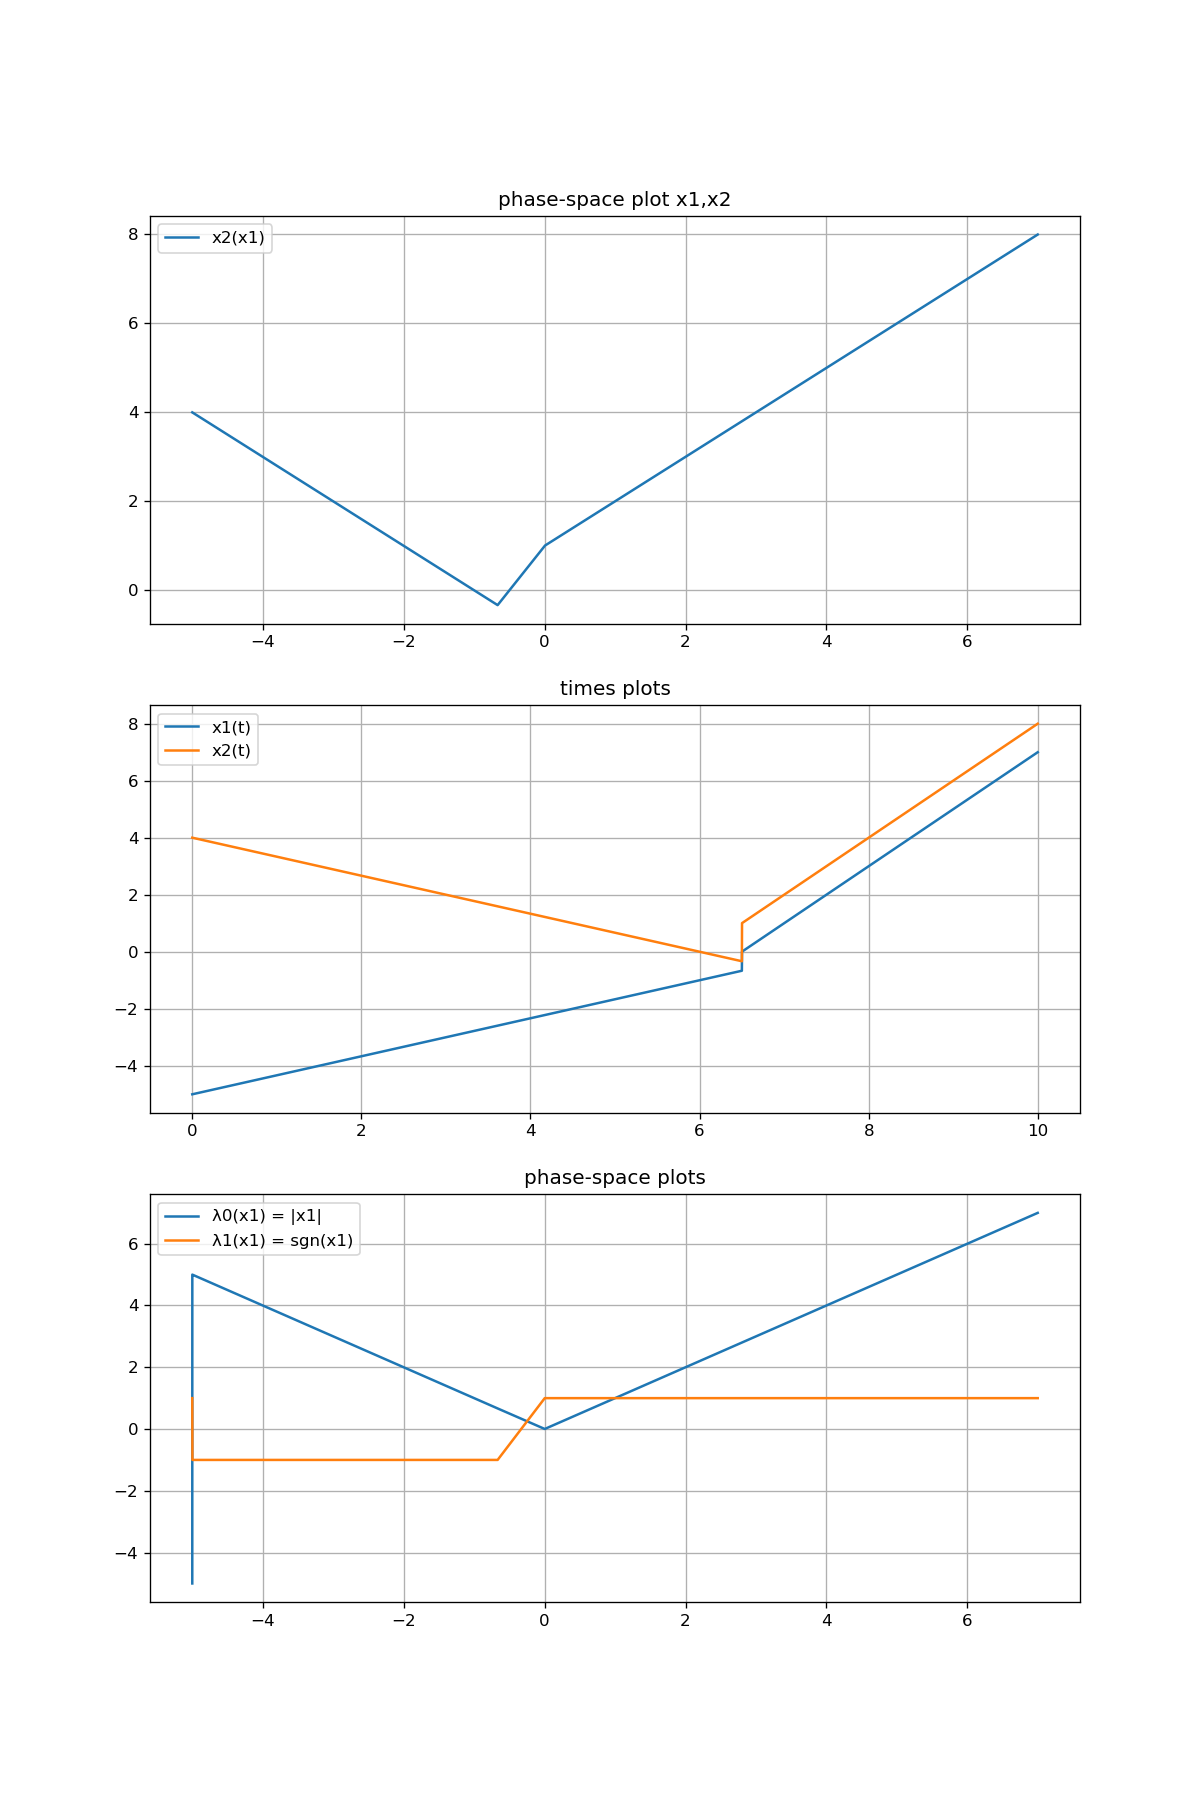

<IPython.core.display.Javascript object>


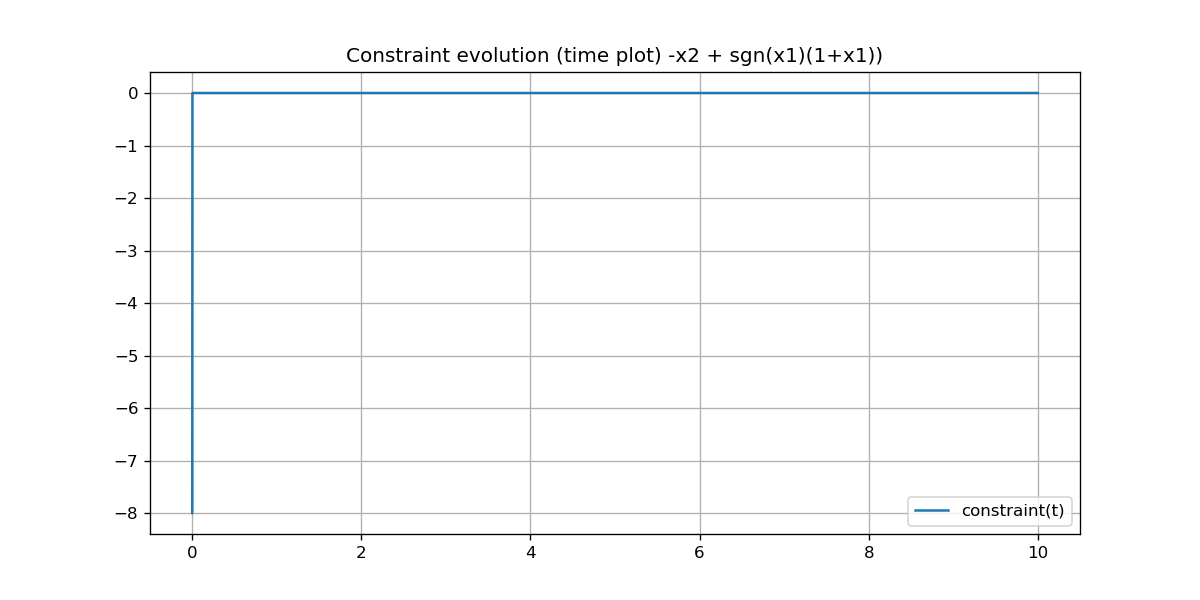

<IPython.core.display.Javascript object>


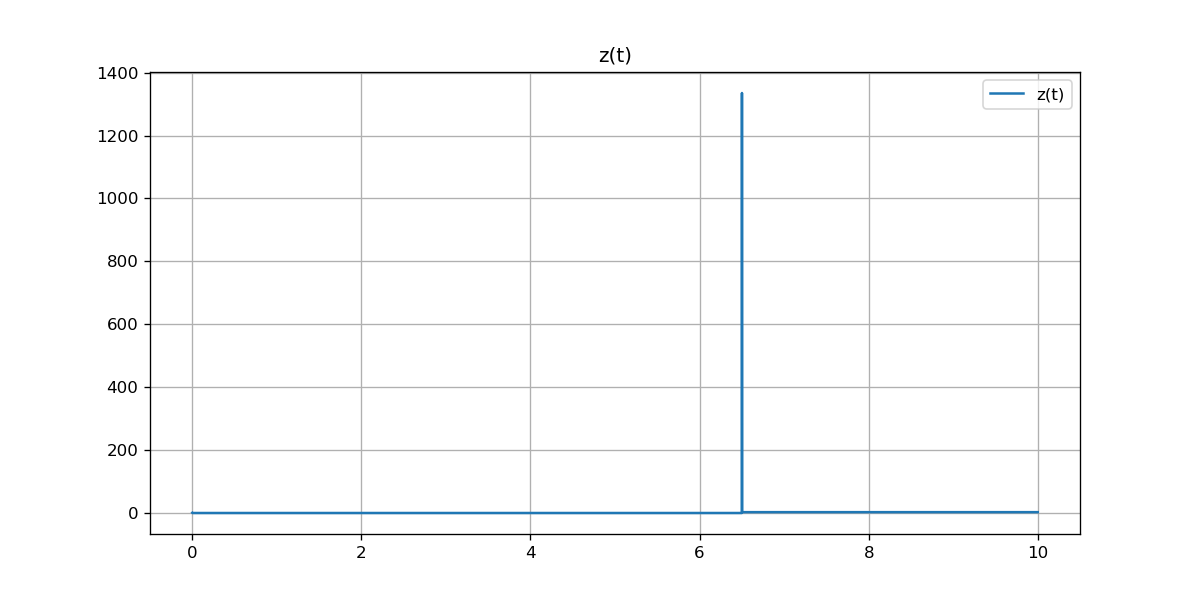

In [2]:
import siconos.numerics as sn
import scipy.linalg as linalg
import numpy as np
import siconos.kernel as sk
from numpy import eye, empty, float64, zeros, transpose, array
from siconos.kernel import FirstOrderLinearTIDS, FirstOrderType2R, FirstOrderLinearTIR, EqualityConditionNSL, RelayNSL,\
                           ComplementarityConditionNSL, NonSmoothDynamicalSystem, Interaction, \
                           EulerMoreauOSI, MoreauJeanOSI, LCP, TimeDiscretisation, TimeStepping 
import siconos.numerics as sn

z0    = 0 

## Initial Conditions
# x10   = -2       
# x20   = 0. 
#####
# x10   = -5       
# x20   = 5.
####
x10   = -5       
x20   = 4. 
###
# x10   = 0.5       
# x20   = 0.5 
###
# x10   = -1.      
# x20   = 0. 
########

t0    = 0.      # start time
T     = 10      # end time 


### Various values of B #####
# _B = [0.13,0.86]
# _B = [-0.5,1.]
#_B = [-0.01,-0.99]
# _B = [-1,0.5]
# _B = [0,1]
_B = [0.5,1]


_A = zeros((3,3))
_A[0,2] = _B[0]
_A[1,2] = _B[1]
_A[2,1] = -1
_A[2,0] = 1

_b = [1,0,1]  
# _b = [1,0,-1] # other possible LCP writing

print("A = ")
print(_A)

print("b = ")
print(_b)

_E = np.eye(3)
_E[2,2] = 0
print("E = ")
print(_E)


# Linear ODE system with time invariant coefficients
dyn = FirstOrderLinearTIDS([x10,x20,z0],_A)
dyn.setbPtr(_b)
dyn.setMPtr(_E)

switch = NonSmoothDynamicalSystem(t0, T)
switch.insertDynamicalSystem(dyn)

####################################################

#
R= zeros((3,3));
R[2,0] = 1 
R[2,1] = -1
# R[2,0] = 1 # other possible LCP writing
# R[2,1] = 1 # other possible LCP writing
print("R = ")
print(R)

C = zeros((3,3)); 
C[0,0] = 2; 
C[1,0] = 1;
# C[0,0] = 2;  # other possible LCP writing
# C[1,0] = -1; # other possible LCP writing
print("C = ")
print(C)

D = zeros((3,3)); 
D[0,0] = 1;
D[1,2] = 1; 
D[2,1] = -1;
# D[0,0] = 1; # other possible LCP writing
# D[1,2] = 1;  # other possible LCP writing
# D[2,1] = -1;  # other possible LCP writing
print("D = ")
print(D)

e = [0,0,2] # constant parts in LCP left hand sides

# Declaration of the left hand side of the LCP in the form
# C1*x + D1*λ + e1
# Using the matrices previously defined
# R1 is built the such that dx/dt = A*x + R1*λ + b
rel_python_1 = sk.FirstOrderLinearTIR(C, R)
rel_python_1.setDPtr(D)
rel_python_1.setePtr(e)

# Declaration that right side is an LCP
nslaw1 = ComplementarityConditionNSL(3)

# Link between left hand side et right hand side of the LCP
# 0=< C1*x + D1*λ + e1 _|_ λ>= 0
interaction_1 = Interaction(nslaw1, rel_python_1)

switch.link(interaction_1, dyn)

# Discretization and non-smooth problem formulation (LCP)
θ = 1.
γ = 1.
#osi = EulerMoreauOSI(θ)  # One Step time Integrator for First Order Dynamical Systems.
# Simple theta method (~backward euler)
osi = EulerMoreauOSI(θ,γ)  # One Step time Integrator for First Order Dynamical Systems.

osnspb = sk.LCP()


# Simulation and time discretisation
time_step = 0.001 #0.001 # 0.012 
td = TimeDiscretisation(t0, time_step)
simu = TimeStepping(switch, td, osi, osnspb)

##########################################################################
## !!! ALWAYS DECLARE COMPUTE RESIDUY and R for NonLinear Relations !!!!
##         OTHERWISE NEWTOWN ALG DO NOT USE JACOBIANS 
#########################################################################
# simu.setComputeResiduY(True)
# simu.setComputeResiduR(True)
# simu.setNewtonMaxIteration(100) #100 more funcky
# simu.setNewtonTolerance(1e-10)
##########################################################################

##### Simulation run
x = dyn.x() # tracking state variables form ODE
λ = interaction_1.lambda_(0) # tracking λ variables form LCP
k = 0

##### Numpy array used to save data at each time step, for post-processing
N = int((T - t0) / simu.timeStep()) + 1
data_plot = zeros((N, 6))

###### Initial state
data_plot[k, 0] = t0
data_plot[k, 1] = x[0] # x1
data_plot[k, 2] = x[1] # x2
data_plot[k, 3] = x[2] # z
data_plot[k, 4] = λ[0] # 1-|x1|
data_plot[k, 5] = λ[1] # 1-sgn(x1)
k += 1

while simu.hasNextEvent():
    
    simu.computeOneStep() # Build and solve the LCP    
#     osnspb.display()
    data_plot[k, 0] = simu.nextTime()
    data_plot[k, 1] = x[0] # x1
    data_plot[k, 2] = x[1] # x2
    data_plot[k, 3] = x[2] # z
    data_plot[k, 4] = λ[0] # |x1|
    data_plot[k, 5] = λ[1] # sgn(x1)
    k += 1 
    #rel_python.display()
    simu.nextStep() # Save current state and prepare next step

print(k)

import ipympl
import matplotlib.pyplot as plt
%matplotlib notebook

plt.figure(figsize=(10,15))
plt.subplot(311)
plt.title('phase-space plot x1,x2')
plt.plot(data_plot[0:k - 1, 1], data_plot[0:k - 1, 2],label='x2(x1)')
plt.legend()
plt.grid()
plt.subplot(312)
plt.title('times plots')
plt.plot(data_plot[0:k - 1, 0], data_plot[0:k - 1, 1],label='x1(t)')
plt.plot(data_plot[0:k - 1, 0], data_plot[0:k - 1, 2],label='x2(t)')
plt.legend()
plt.grid()
plt.subplot(313)
plt.title('phase-space plots')
plt.plot(data_plot[0:k - 1, 1], data_plot[0:k - 1, 1] + data_plot[0:k - 1, 4],label='λ0(x1) = |x1|')
plt.plot(data_plot[0:k - 1, 1], 1-data_plot[0:k - 1, 5],label='λ1(x1) = sgn(x1)')
plt.legend()
plt.grid()

constraint = -data_plot[0:k - 1, 2] + (1-data_plot[0:k - 1, 5])*(1 + data_plot[0:k - 1, 1]) 
plt.figure(figsize=(10,5))
plt.title('Constraint evolution (time plot) -x2 + sgn(x1)(1+x1))')
plt.plot(data_plot[0:k - 1, 0], constraint,label='constraint(t)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.title('z(t)')
plt.plot(data_plot[0:k - 1, 0], data_plot[0:k - 1, 3],label='z(t)')
plt.legend()
plt.grid()
plt.show()